### モジュールの import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import datasets, transforms, models
import torch.optim as optim

### Transform、Dataset、DataLoader を作成する。

In [2]:
data_transforms = {
    # 学習時の Transform
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    # 推論時の Transform
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

# Dataset を作成する。
dataset_dir = Path("/data/imagenette-320")   # imagenette-320 ディレクトリがある場所
assert dataset_dir.exists()
img_datasets = {
    x: datasets.ImageFolder(dataset_dir / x, data_transforms[x])
    for x in ["train", "val"]
}

# DataLoader を作成する
dataloaders = {
    x: data.DataLoader(img_datasets[x], batch_size=4, shuffle=True, num_workers=8)
    for x in ["train", "val"]
}

### モデル、損失関数、オプティマイザを作成する

In [3]:
# デバイスを作成する。
device = torch.device("cuda")

# モデルを作成する。
model = models.mobilenet_v2(pretrained=True).to(device)

# 損失関数を作成する。
criterion = nn.CrossEntropyLoss()

# オプティマイザを作成する。
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# スケジューラーを作成する。
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### 学習する

In [4]:
def train_on_epoch():
    info = {}
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # モデルを学習モードに設定する。
        else:
            model.eval()  # モデルを推論モードに設定する。

        total_loss = 0
        total_correct = 0
        for inputs, labels in dataloaders[phase]:
            # データ及びラベルを計算を実行するデバイスに転送する。
            inputs, labels = inputs.to(device), labels.to(device)

            # 学習時は勾配を計算するため、set_grad_enabled(True) で中間層の出力を記録するように設定する。
            with torch.set_grad_enabled(phase == "train"):
                # 順伝搬を行う。
                outputs = model(inputs)
                # 確率の最も高いクラスを予測ラベルとする。
                preds = outputs.argmax(dim=1)

                # 損失関数の値を計算する。
                loss = criterion(outputs, labels)

                if phase == "train":
                    # 逆伝搬を行う。
                    optimizer.zero_grad()
                    loss.backward()

                    # パラメータを更新する。
                    optimizer.step()

            # この反復の損失及び正答数を加算する。
            total_loss += float(loss)
            total_correct += int((preds == labels).sum())

        if phase == "train":
            # 学習率を調整する。
            scheduler.step()

        # 損失関数の値の平均及び精度を計算する。
        info[f"{phase}_loss"] = total_loss / len(dataloaders[phase].dataset)
        info[f"{phase}_accuracy"] = total_correct / len(dataloaders[phase].dataset)

    return info

In [5]:
def train(n_epochs):
    """指定したエポック数だけ学習する。
    """
    history = []
    for epoch in range(n_epochs):
        info = train_on_epoch()
        info["epoch"] = epoch + 1
        history.append(info)

        print(
            f"epoch {info['epoch']:<2} "
            f"[train] loss: {info['train_loss']:.6f}, accuracy: {info['train_accuracy']:.0%} "
            f"[test] loss: {info['val_loss']:.6f}, accuracy: {info['val_accuracy']:.0%}"
        )
    history = pd.DataFrame(history)

    return history

history = train(n_epochs=10)

epoch 1  [train] loss: 0.302804, accuracy: 63% [test] loss: 0.067403, accuracy: 92%
epoch 2  [train] loss: 0.182649, accuracy: 77% [test] loss: 0.044355, accuracy: 94%
epoch 3  [train] loss: 0.160486, accuracy: 80% [test] loss: 0.042276, accuracy: 95%
epoch 4  [train] loss: 0.144827, accuracy: 82% [test] loss: 0.044764, accuracy: 94%
epoch 5  [train] loss: 0.134598, accuracy: 83% [test] loss: 0.040417, accuracy: 95%
epoch 6  [train] loss: 0.129460, accuracy: 84% [test] loss: 0.040925, accuracy: 96%
epoch 7  [train] loss: 0.116486, accuracy: 85% [test] loss: 0.040564, accuracy: 95%
epoch 8  [train] loss: 0.089796, accuracy: 89% [test] loss: 0.027497, accuracy: 97%
epoch 9  [train] loss: 0.077316, accuracy: 90% [test] loss: 0.028123, accuracy: 96%
epoch 10 [train] loss: 0.073689, accuracy: 91% [test] loss: 0.028454, accuracy: 96%


### 学習の推移をグラフにする

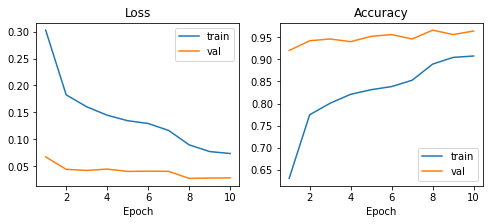

In [6]:
def plot_history(history):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

    # 損失の推移
    ax1.set_title("Loss")
    ax1.plot(history["epoch"], history["train_loss"], label="train")
    ax1.plot(history["epoch"], history["val_loss"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # 精度の推移
    ax2.set_title("Accuracy")
    ax2.plot(history["epoch"], history["train_accuracy"], label="train")
    ax2.plot(history["epoch"], history["val_accuracy"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()


plot_history(history)